In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
location = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')
selected_data = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data3.csv'))
#selected_data.set_index('timestamp', inplace=True)

In [5]:
from src.data.utils import get_input_data
data = get_input_data(data_folder, location, turbine)
#data['turbine_data'].columns

In [6]:
data['mvbc_data'].isna().sum()

mvbc_WandelaarBuoy_10%_highest_waves                                        0
mvbc_WandelaarBuoy_Wave_height                                              0
mvbc_WandelaarBuoy_Average_wave_period                                      0
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                          0
mvbc_WandelaarBuoy_Sea_water_temperature                                 3834
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)        2
mvbc_WandelaarMeasuringpile_Average_wind_direction                          0
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)             2
mvbc_WandelaarMeasuringpile_Tide_TAW                                        0
mvbc_WandelaarMeasuringpile_Relative_humidity                           13250
mvbc_WandelaarMeasuringpile_Air_pressure                                   22
mvbc_WandelaarMeasuringpile_Air_temperature                                 0
dtype: int64

In [7]:
data['turbine_data'].isna().sum()

location                          0
mean_NW2_C02_rpm               1029
mean_NW2_C02_yaw               1029
std_NW2_C02_pitch               883
mean_NW2_C02_pitch             1029
mean_NW2_C02_power             1029
std_NW2_C02_towerxacc         27798
std_NW2_C02_toweryacc         27798
std_NW2_C02_windspeed          1029
mean_NW2_C02_towerxacc        27798
mean_NW2_C02_toweryacc        27798
mean_NW2_C02_windspeed         1029
mean_NW2_C02_winddirection     1029
mpe_NW2_C02_FA                   18
mpe_NW2_C02_SS                   17
mpe_NW2_C02_FA1               12210
mpe_NW2_C02_SS1                 369
max_NW2_C02_NAC_ACC_Z            17
min_NW2_C02_NAC_ACC_Z            17
rms_NW2_C02_NAC_ACC_Z            17
std_NW2_C02_NAC_ACC_Z           107
max_NW2_C02_NAC_ACC_FA           17
max_NW2_C02_NAC_ACC_SS           17
mean_NW2_C02_NAC_ACC_Z          107
min_NW2_C02_NAC_ACC_FA           17
min_NW2_C02_NAC_ACC_SS           17
rms_NW2_C02_NAC_ACC_FA           17
rms_NW2_C02_NAC_ACC_SS      

In [8]:
from src.data.harmonics import *
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [9]:
from src.data.make_dataset import create_input_target_dataset
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

y_train = selected_data_unique[['mean_frequency']].set_index(selected_data_unique['timestamp'])
y_train.index = pd.to_datetime(y_train.index)
y_train = y_train.loc[y_train.index.intersection(X.index)]
X_train = X.loc[y_train.index]

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


In [10]:
X_train = X_train[['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature']]

In [11]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
#X_train = X_train.drop(['mvbc_WandelaarMeasuringpile_Tide_TAW'], axis=1)
#regr_model = CatBoostRegressor(iterations=100, random_seed=13, posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)

regr_model.fit(X_train, y_train)

In [12]:
# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty

In [13]:
#smart tracking
def smart_tracking(calculated_mode, predictions, uncertainties:pd.Series, uncerainty_threshold, distance_threshold):
    tracked_modes = pd.DataFrame(calculated_mode.values, index=calculated_mode.index, columns=['frequency'])
    tracked_modes = tracked_modes.loc[uncertainties[uncertainties < uncerainty_threshold].index]
    tracked_modes['distance_to_prediction'] = np.abs(tracked_modes['frequency'] - predictions.loc[tracked_modes.index])
    smart_tracked_modes = tracked_modes[tracked_modes['distance_to_prediction'] < distance_threshold]
    return smart_tracked_modes
    
    

C:\Users\Max\AppData\Local\Temp\ipykernel_13072\283961327.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_13072\283961327.py:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


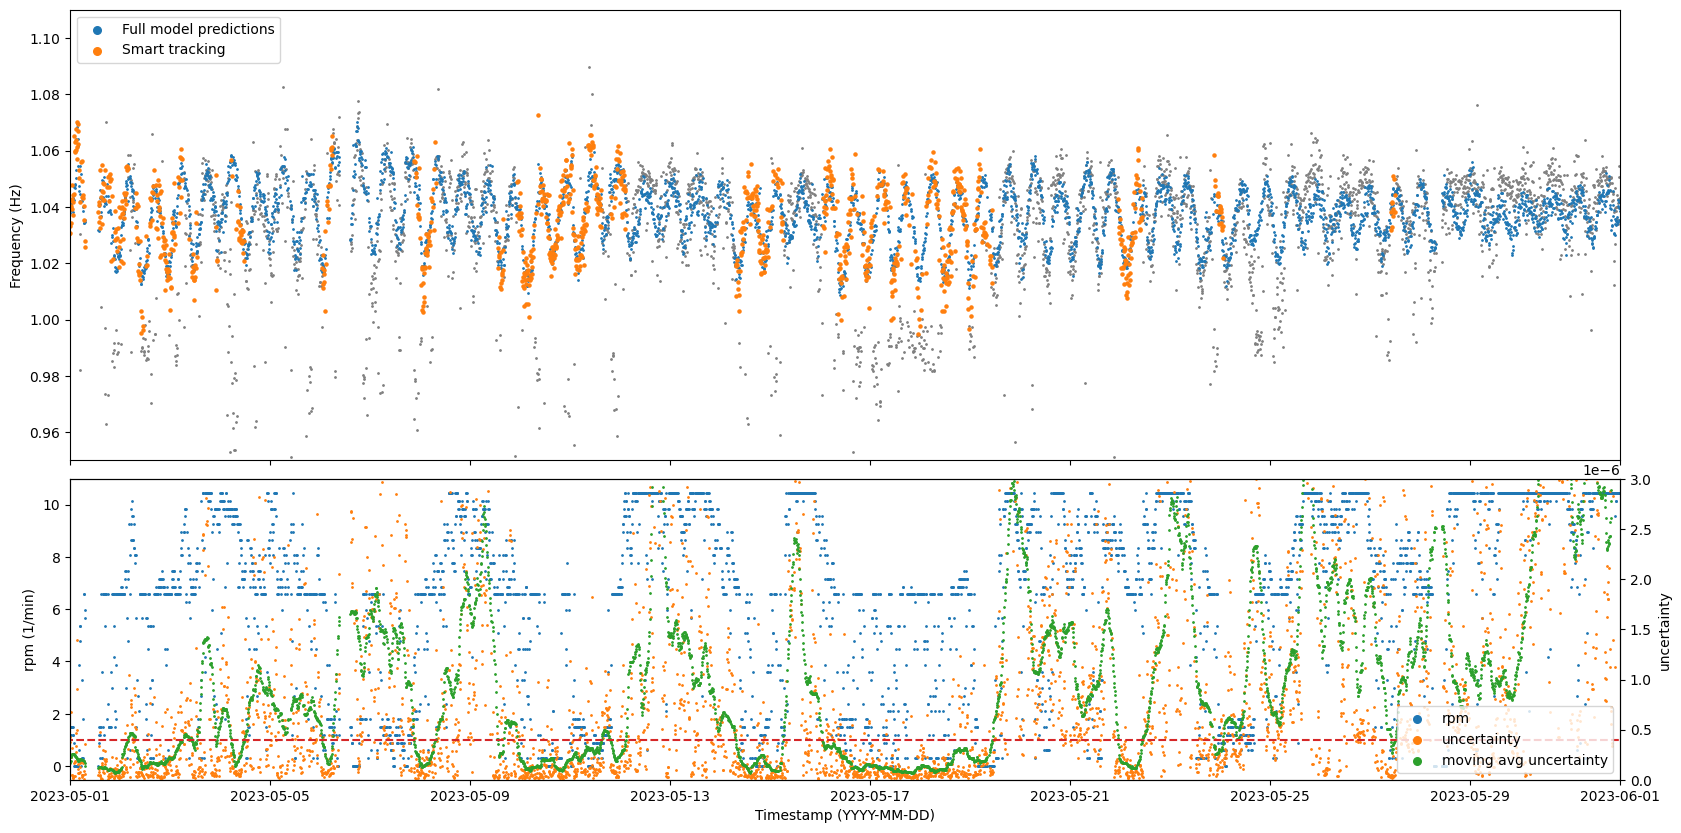

In [50]:
import matplotlib.pyplot as plt
import datetime

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = 0.4*1e-6

smart_tracked_modes = smart_tracking(y, predictions_df['prediction'], uncertainty_moving_avg, uncertainty_lim, 0.02)

y_low_uncertainty = y.loc[uncertainty_moving_avg < uncertainty_lim]
# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
#ax1.scatter(y_low_uncertainty.index, y_low_uncertainty, s=5, color='tab:blue', label='low uncertainty')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=1, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=5, color='tab:orange', label='Smart tracking')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left')
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 5, 1), datetime.datetime(2023, 6, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

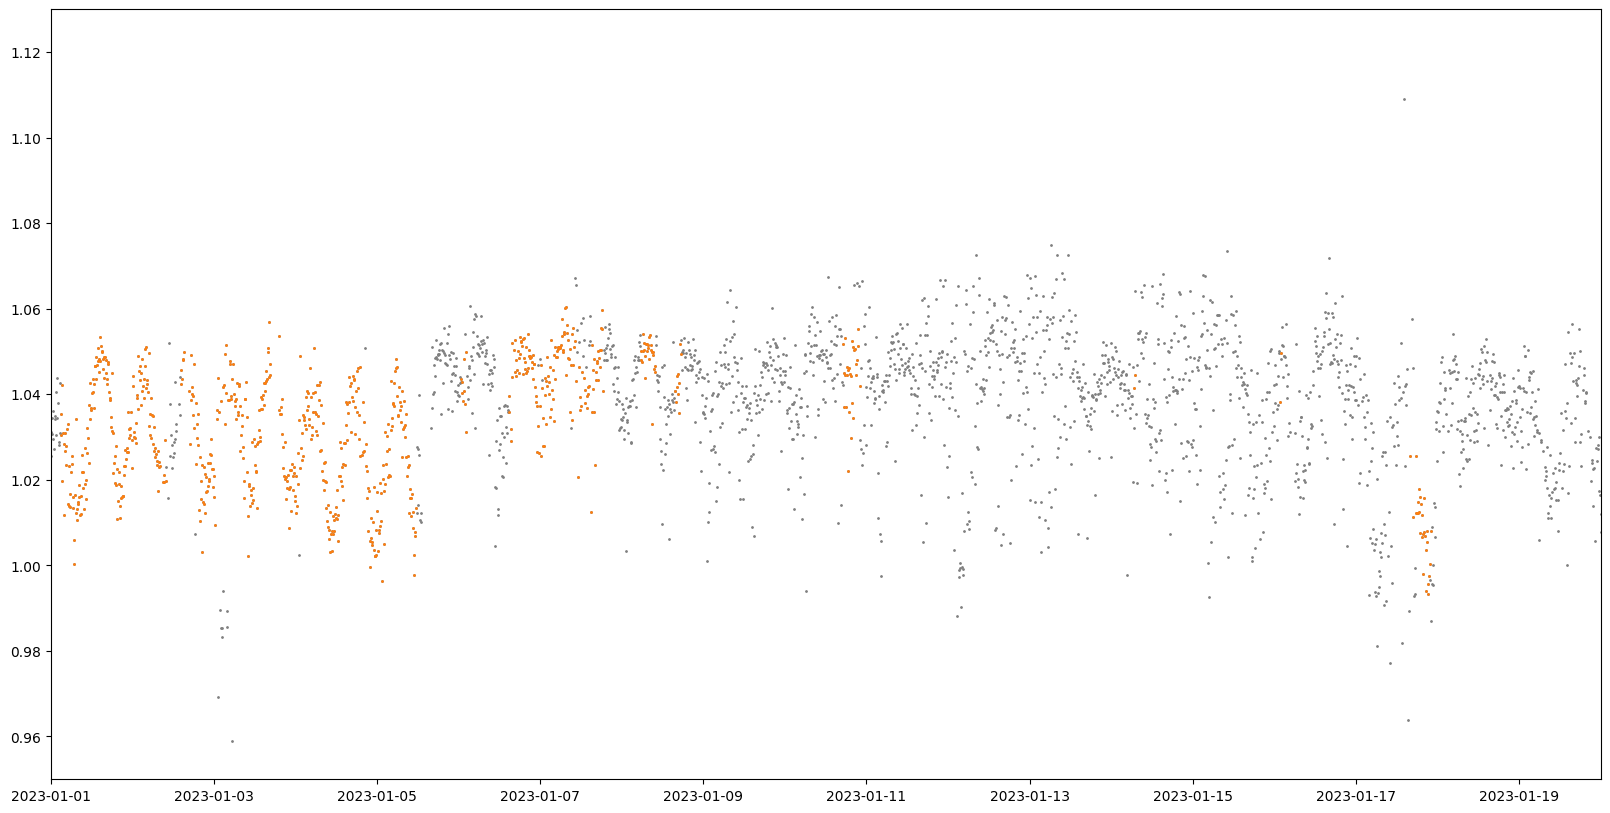

In [51]:
plt.figure(figsize=(20,10))
plt.scatter(y.index, y, s=1, color='grey')
plt.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Full model predictions')
plt.xlim(datetime.datetime(2023, 1, 1), datetime.datetime(2023, 1, 20))
plt.ylim(0.95, 1.13)
plt.show()
plt.close()

C:\Users\Max\AppData\Local\Temp\ipykernel_13072\1443686468.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend1.legendHandles:
C:\Users\Max\AppData\Local\Temp\ipykernel_13072\1443686468.py:56: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in combined_legend.legendHandles:


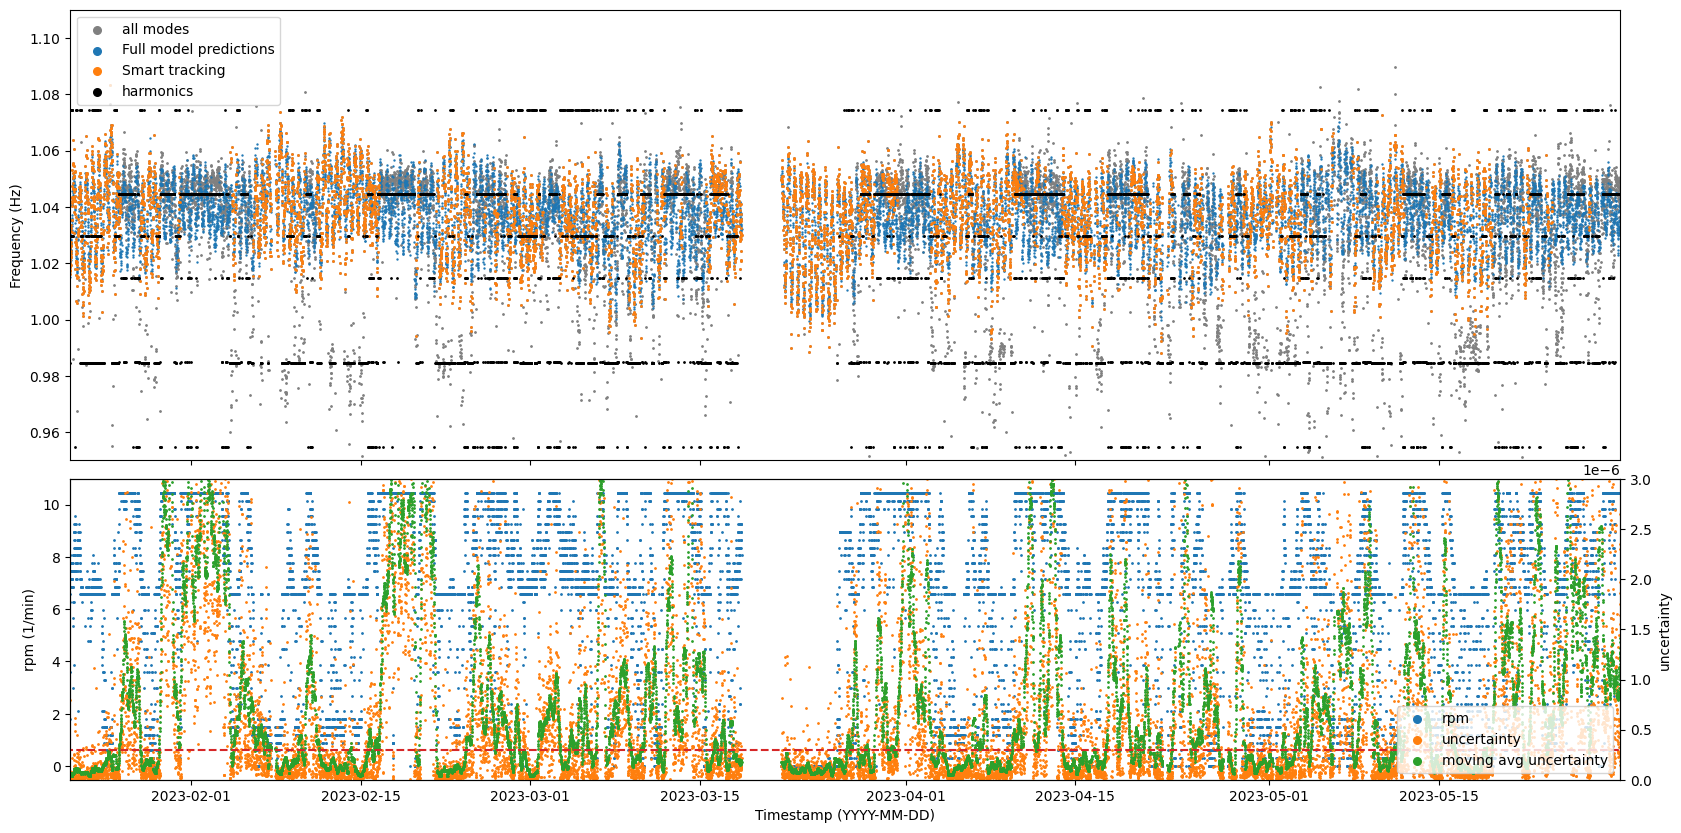

In [46]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=1, color='grey')
ax1.scatter(predictions_df.index, predictions_df['prediction'], s=0.5, color='tab:blue', label='Full model predictions')
ax1.scatter(smart_tracked_modes.index, smart_tracked_modes['frequency'], s=1, color='tab:orange', label='Smart tracking')
for harmonic in harmonics_data.columns:
    ax1.scatter(harmonics_data.index, harmonics_data[harmonic], color='k', s=1)

#ax1.plot(harmonics_data, color='k', linestyle='--', linewidth=0.5, label='harmonics')
#ax1.scatter(y_train.index, y_train, s=3, color='tab:blue', label='training data')
#ax1.scatter(y.index, predicted_value, s=2, color='tab:orange', label='Full model predictions')


#ax1.scatter(y.index, virtual_ensemble_preds_mean, s=2, color='tab:green', label='Virtual ensemble mean predictions')

ax1.set_ylim(0.95, 1.11)
legend1 = ax1.legend(loc='upper left', labels = ['all modes', 'Full model predictions', 'Smart tracking', 'harmonics'])
for handle in legend1.legendHandles:
    handle.set_sizes([30])
ax1.set_ylabel('Frequency (Hz)')


# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')
#ax2.scatter(X.index, data_uncertainty, label='data uncertainty', s=1, color='tab:blue')
#ax2.set_ylim(0, 1e-5)

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
ax3 = ax2.twinx()
ax3.scatter(uncertainty_.index,uncertainty_, label='uncertainty', s=1, color='tab:orange')
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
ax3.scatter(uncertainty_moving_avg.index,uncertainty_moving_avg, label='moving avg uncertainty', s=1, color='tab:green')

uncertainty_lim = 0.3*1e-6
ax3.hlines(uncertainty_lim, uncertainty_.index[0], uncertainty_.index[-1], color='tab:red', linestyles='dashed')
ax3.set_ylabel('uncertainty')
ax3.set_ylim(0, 3*1e-6)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
combined_legend = plt.legend(combined_handles, combined_labels, loc='lower right')
for handle in combined_legend.legendHandles:
    handle.set_sizes([30])

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 1, 22), datetime.datetime(2023, 5, 30))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()

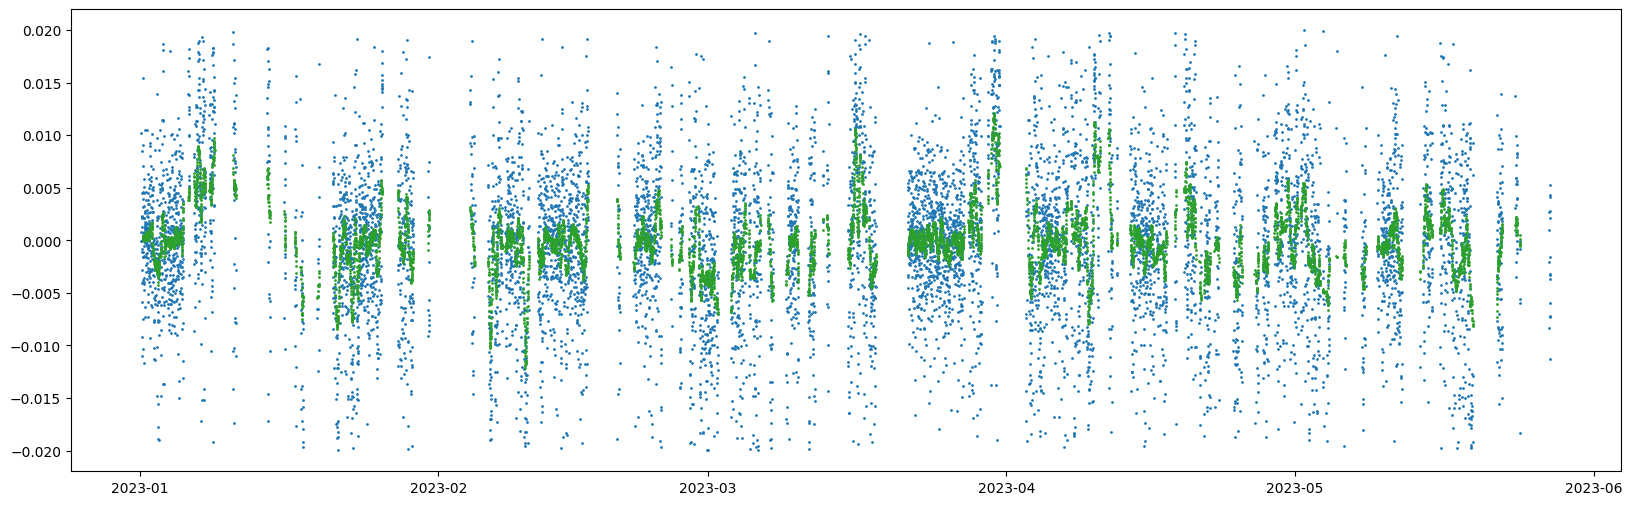

In [47]:
plt.figure(figsize=(20,6))
residual = (y - predictions_df['prediction']).loc[smart_tracked_modes.index]
residual_moving_avg = residual.rolling(6*6, center=True).mean()
plt.scatter(residual.index, residual, s=1, color='tab:blue')
plt.scatter(residual_moving_avg.index, residual_moving_avg, s=1, color='tab:green')


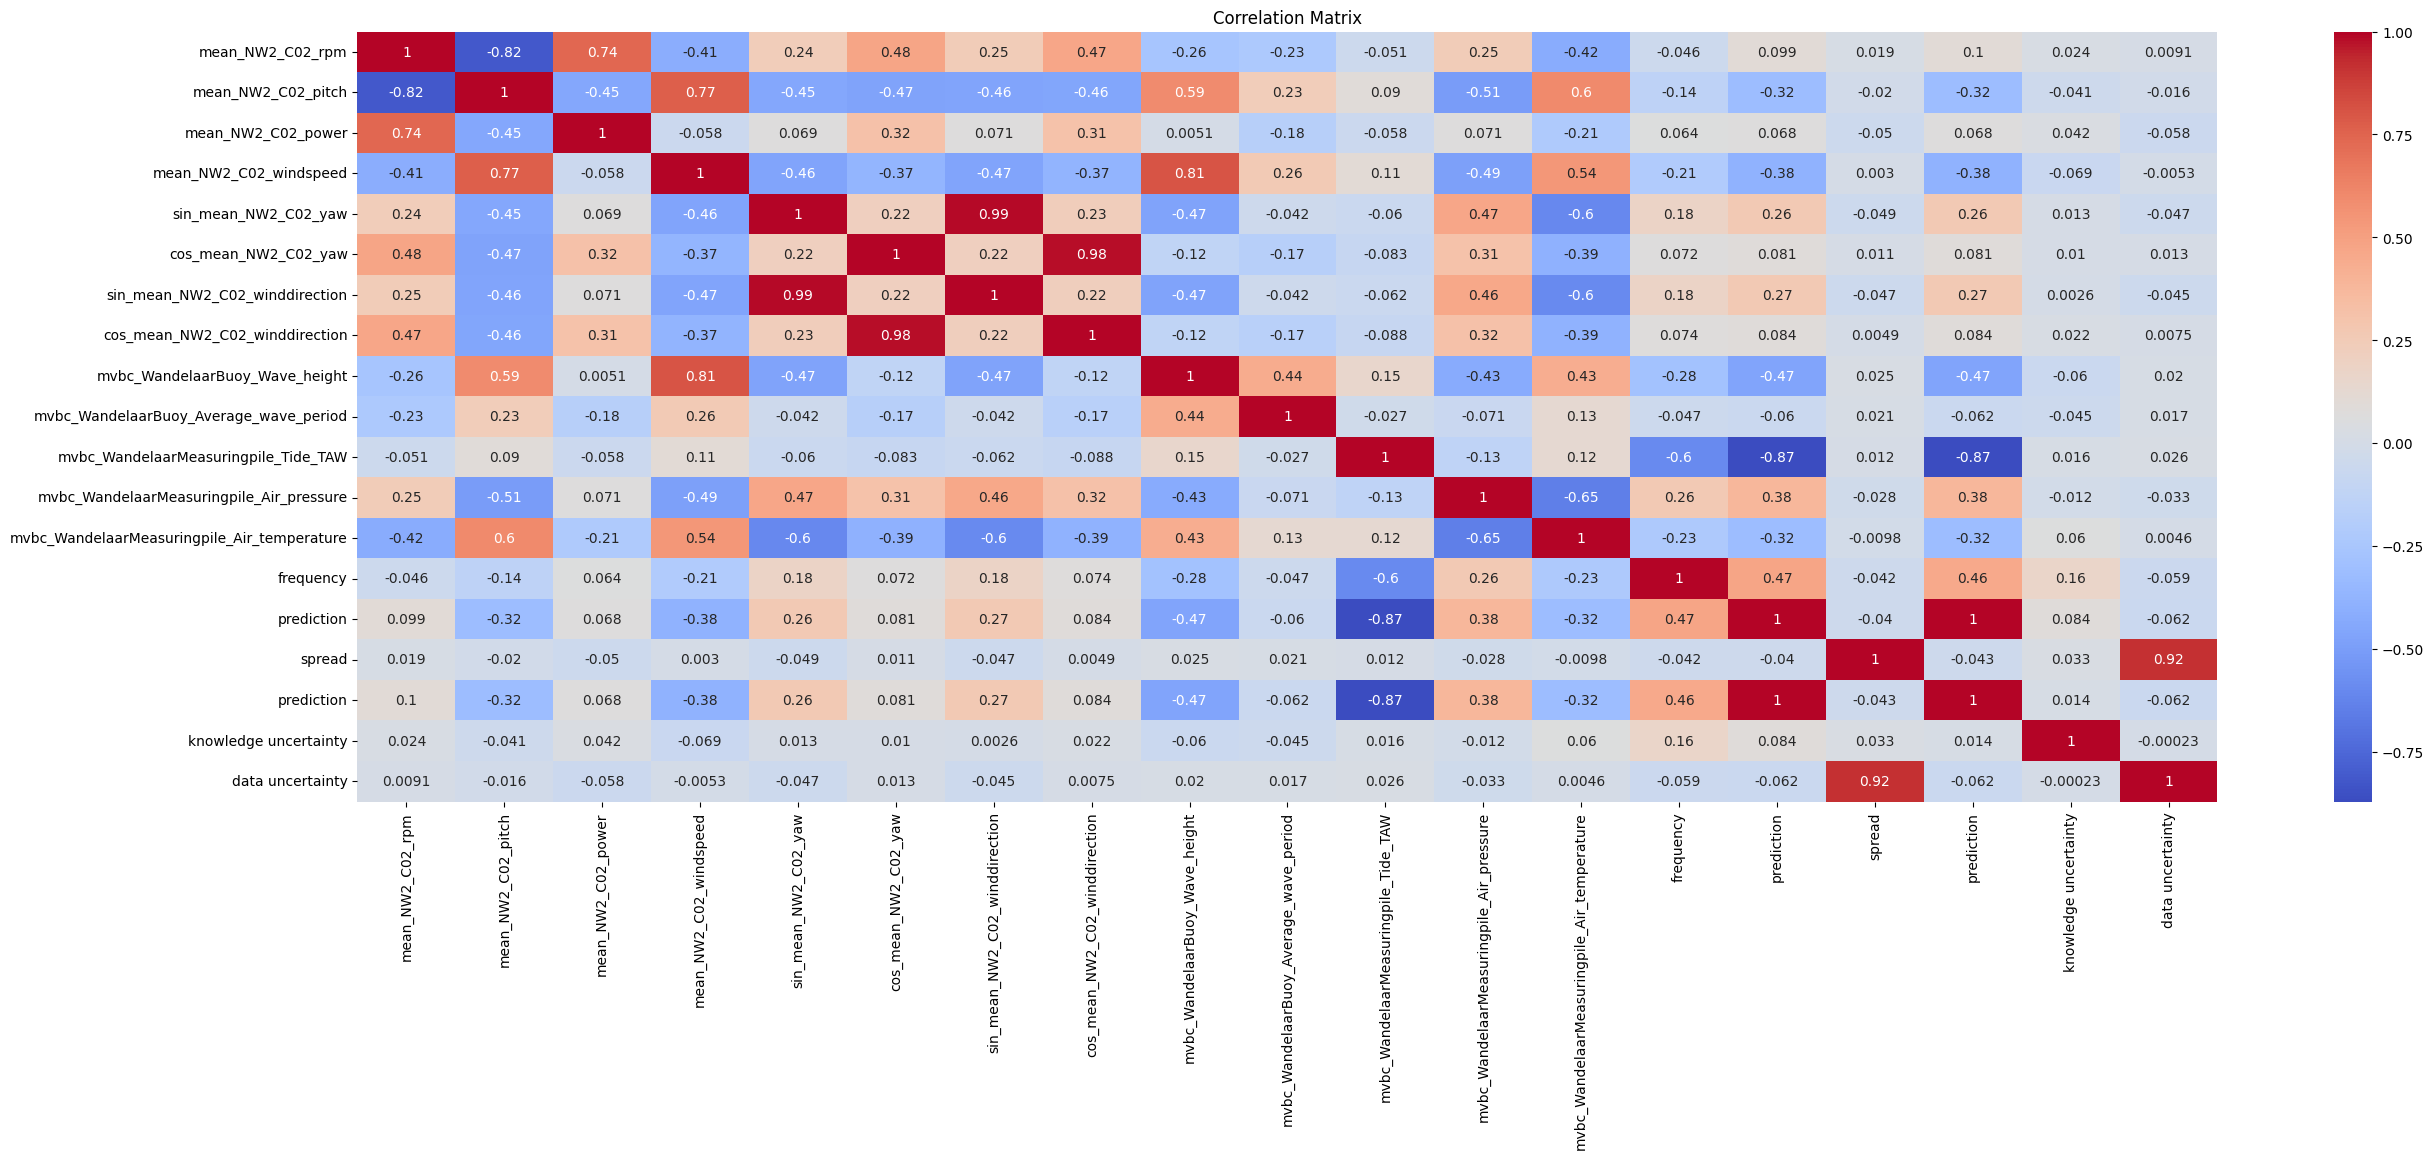

In [48]:
import seaborn as sns
all_data = pd.concat([X_train, y, predictions_df, virtual_ensemble_preds_df], axis=1)

plt.figure(figsize=(30, 10))
correlation_matrix = all_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'mean_NW2_C02_rpm'),
  Text(1, 0, 'mean_NW2_C02_pitch'),
  Text(2, 0, 'mean_NW2_C02_power'),
  Text(3, 0, 'mean_NW2_C02_windspeed'),
  Text(4, 0, 'sin_mean_NW2_C02_yaw'),
  Text(5, 0, 'cos_mean_NW2_C02_yaw'),
  Text(6, 0, 'sin_mean_NW2_C02_winddirection'),
  Text(7, 0, 'cos_mean_NW2_C02_winddirection'),
  Text(8, 0, 'mvbc_WandelaarBuoy_Wave_height'),
  Text(9, 0, 'mvbc_WandelaarBuoy_Average_wave_period'),
  Text(10, 0, 'mvbc_WandelaarMeasuringpile_Tide_TAW'),
  Text(11, 0, 'mvbc_WandelaarMeasuringpile_Air_pressure'),
  Text(12, 0, 'mvbc_WandelaarMeasuringpile_Air_temperature')])

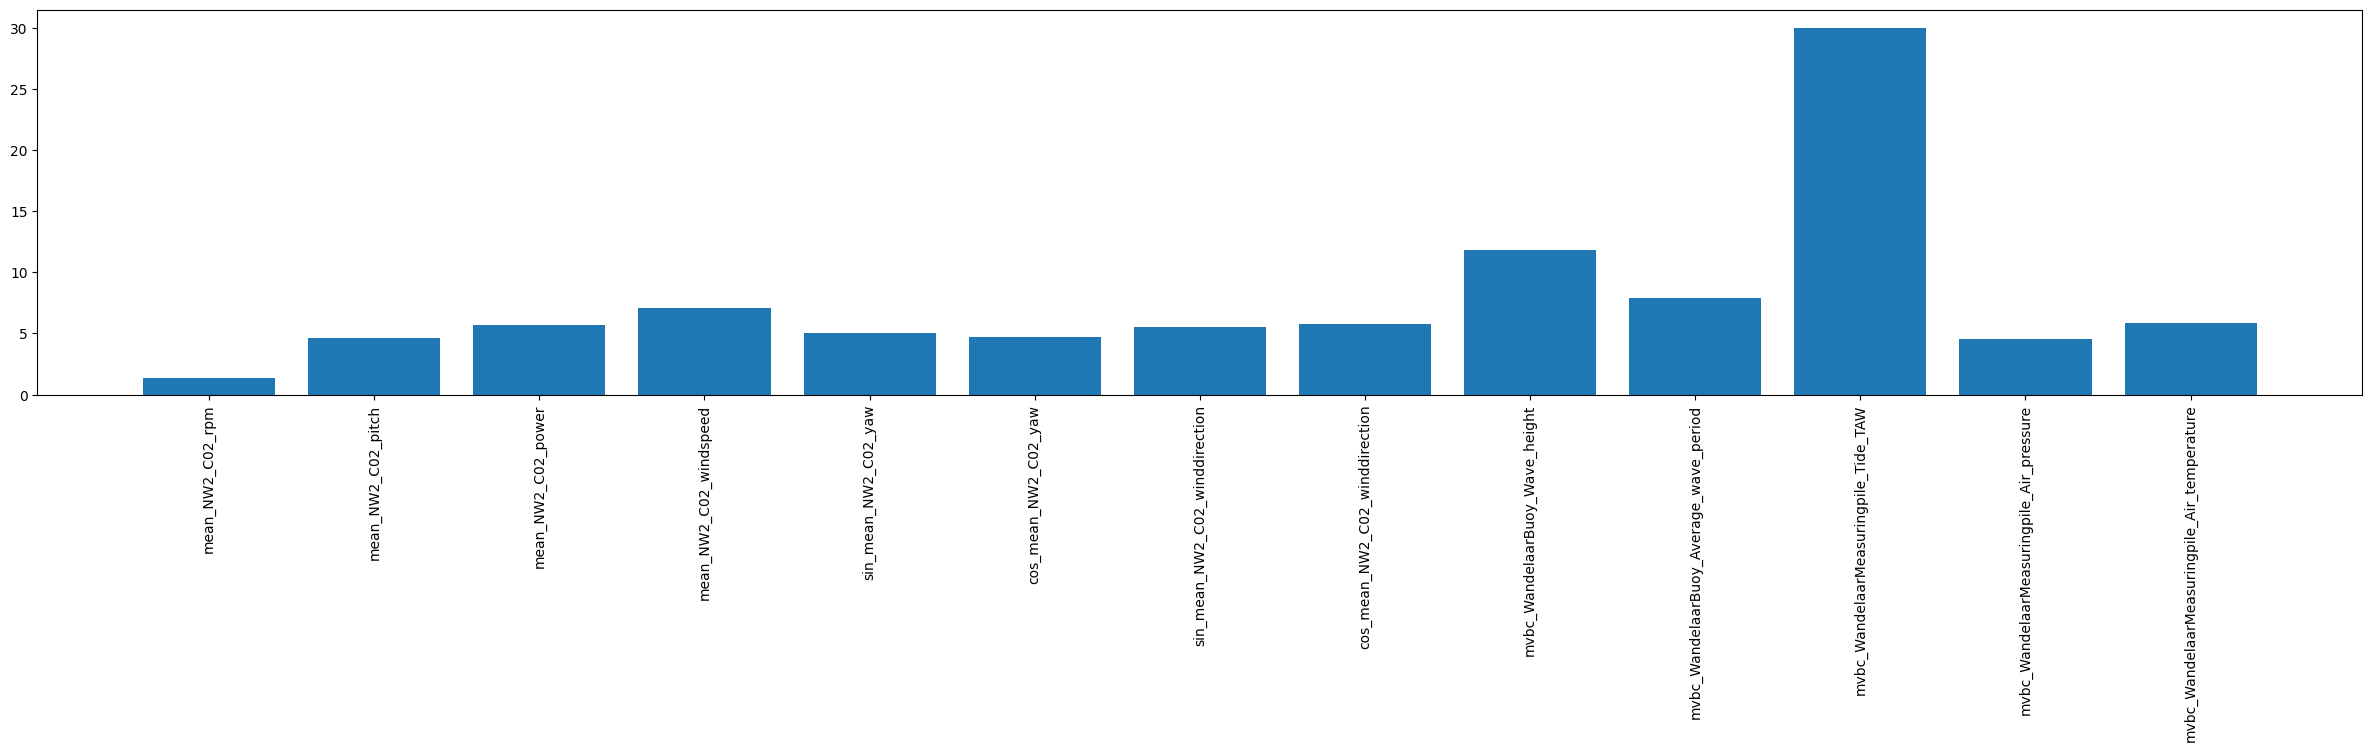

In [49]:
plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)